In [1]:
import rospy
import ros_numpy
import matplotlib.pyplot as plt
import numpy as np
from sensor_msgs.msg import Image as ImageMsg
from PIL import Image

In [2]:
rospy.init_node('collect_images', anonymous=True)

DIR = "Misc"
text_prompt = "rice cooker"

In [13]:
rgb_message_head = rospy.wait_for_message("d415/color/image_raw", ImageMsg)
depth_message_head = rospy.wait_for_message("d415/aligned_depth_to_color/image_raw", ImageMsg)
rgb_data_head = ros_numpy.numpify(rgb_message_head)
depth_data_head = ros_numpy.numpify(depth_message_head)

rgb_message_wrist = rospy.wait_for_message("d405/color/image_rect_raw", ImageMsg)
depth_message_wrist = rospy.wait_for_message("d405/aligned_depth_to_color/image_raw", ImageMsg)
rgb_data_wrist = ros_numpy.numpify(rgb_message_wrist)
depth_data_wrist = ros_numpy.numpify(depth_message_wrist)

print(rgb_data_head.shape)
print(depth_data_head.shape)

print(rgb_data_wrist.shape)
print(depth_data_wrist.shape)

(720, 1280, 3)
(720, 1280)
(480, 848, 3)
(480, 848)


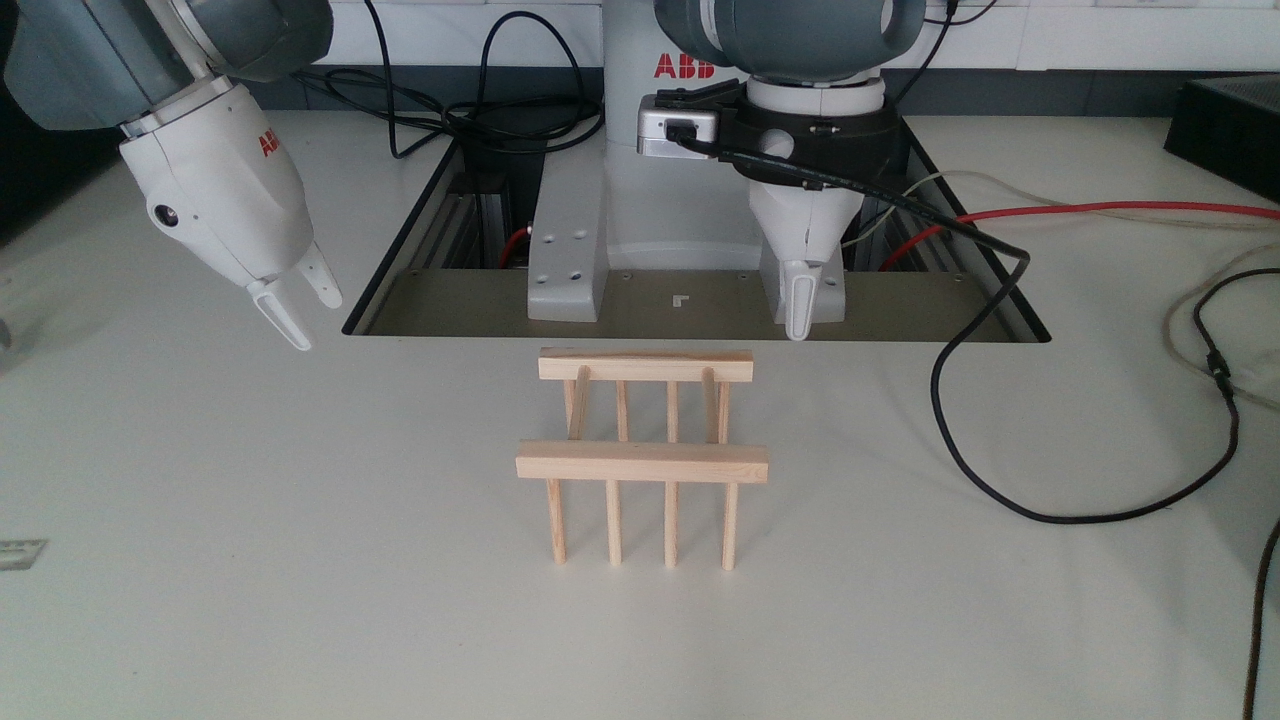

In [4]:
rgb_image_head = Image.fromarray(rgb_data_head)
depth_image_head = Image.fromarray(depth_data_head)
rgb_image_head

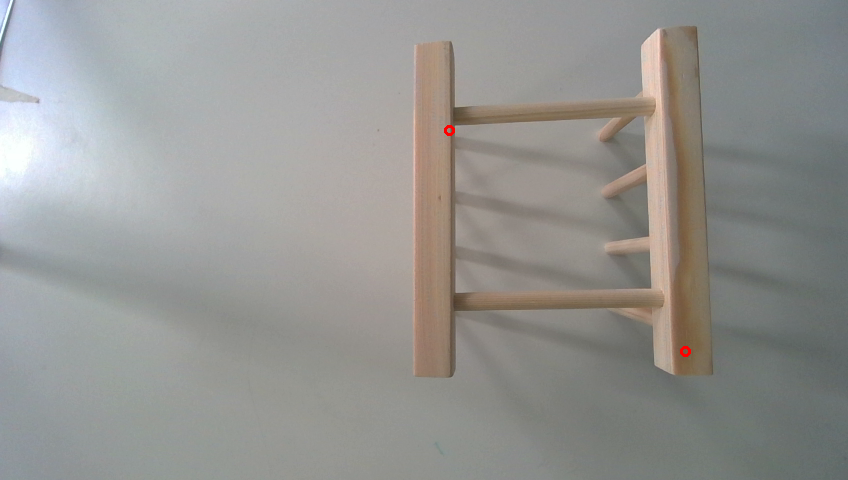

In [12]:
import json
from trajectory_utils import create_homogeneous_matrix, pose_inv
from PIL import ImageDraw

rgb_message_wrist = rospy.wait_for_message("d405/color/image_rect_raw", ImageMsg)
rgb_data_wrist = ros_numpy.numpify(rgb_message_wrist)
rgb_image_wrist = Image.fromarray(rgb_data_wrist)
with open(f"experiments/wood/demo_bottlenecks.json") as f:
    dbn = json.load(f)

demo_waypoints = np.vstack([dbn[key] for key in dbn.keys()])

T_GRIP_EEF = create_homogeneous_matrix([0, 0, 0.136], [0, 0, 0, 1])
K = np.load("handeye/intrinsics_d405.npy")
T_C_EEF = np.load("handeye/T_C_EEF_wrist_l.npy")
point_2Ds = []
T_EEF_World = create_homogeneous_matrix(demo_waypoints[0, :3], demo_waypoints[0, 3:])
for i in range(2, 4):
    point3d = pose_inv(T_C_EEF) @ pose_inv(T_EEF_World) @ create_homogeneous_matrix(demo_waypoints[i, :3], demo_waypoints[i, 3:]) @ T_GRIP_EEF
    
    # Project the 3D point onto the image plane
    point_image_homogeneous = np.dot(K, point3d[:3, 3])
    
    # Normalize the coordinates to get the 2D image point
    point_2D = point_image_homogeneous[:2] / point_image_homogeneous[2]

    point_2Ds.append(point_2D)


draw = ImageDraw.Draw(rgb_image_wrist)

for point_2D in point_2Ds:
    x, y, r = point_2D[0], point_2D[1], 5
    # Draw the circle (ellipse) with bounding box [(x-r, y-r), (x+r, y+r)]
    draw.ellipse((x-r, y-r, x+r, y+r), outline="red", width=3)


# Save or show the image
rgb_image_wrist

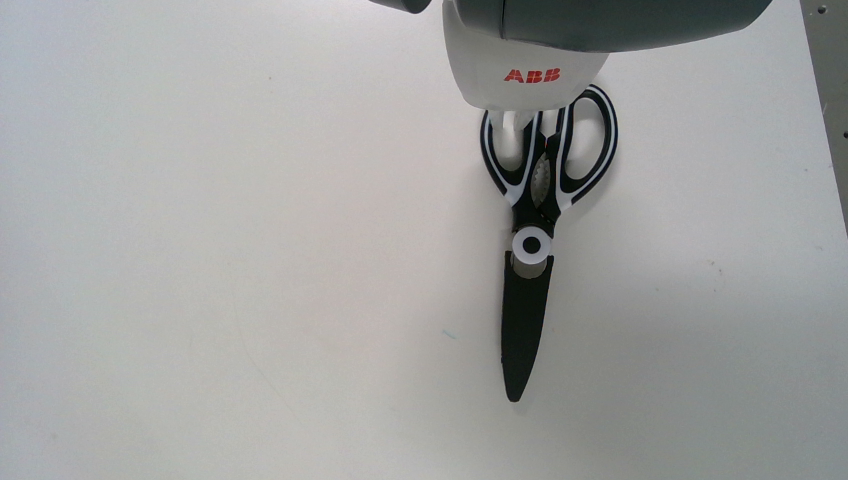

In [7]:
rgb_image_wrist = Image.fromarray(rgb_data_wrist)
depth_image_wrist = Image.fromarray(depth_data_wrist)
rgb_image_wrist

In [21]:
rgb_image_head.save(f"data/{DIR}/demo_head_rgb.png")
depth_image_head.save(f"data/{DIR}/demo_head_depth.png")

rgb_image_wrist.save(f"data/{DIR}/demo_wrist_rgb.png")
depth_image_wrist.save(f"data/{DIR}/demo_wrist_depth.png")

In [2]:
from lang_sam import LangSAM

model = LangSAM()

/home/yilong/.local/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
Model loaded from /home/yilong/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [4]:
# rgb_image = rgb_image_head.copy()
# depth_image =depth_image_head.copy()

def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)

def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i, mask_np in enumerate(masks):
        axes[i+1].imshow(mask_np, cmap='gray')
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def display_image_with_boxes(image, boxes, logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis('off')

    for box, logit in zip(boxes, logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(logit.item(), 2)  # Convert logit to a scalar before rounding
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

        # Add confidence score as text
        ax.text(x_min, y_min, f"Confidence: {confidence_score}", fontsize=8, color='red', verticalalignment='top')

    plt.show()

def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")

def print_detected_phrases(phrases):
    print("\nDetected Phrases:")
    for i, phrase in enumerate(phrases):
        print(f"Phrase {i+1}: {phrase}")

def print_logits(logits):
    print("\nConfidence:")
    for i, logit in enumerate(logits):
        print(f"Logit {i+1}: {logit}")

/home/yilong/.local/lib/python3.8/site-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/yilong/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/yilong/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


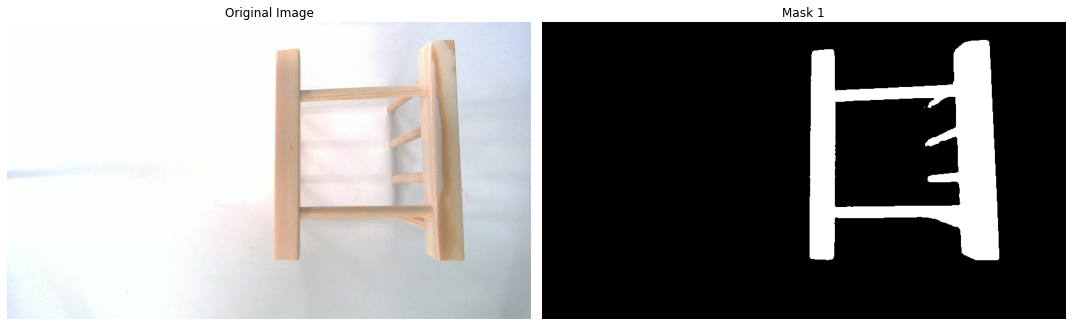

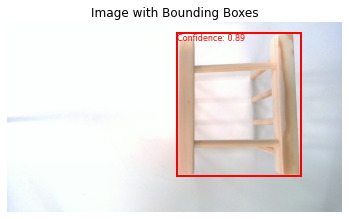

Bounding Boxes:
Box 1: tensor([429.6478,  27.1805, 743.2086, 388.2695])

Detected Phrases:
Phrase 1: wood stand

Confidence:
Logit 1: 0.8858392238616943


In [5]:
image_pil = rgb_image.copy()
masks, boxes, phrases, logits = model.predict(rgb_image, text_prompt)

if len(masks) == 0:
    print(f"No objects of the '{text_prompt}' prompt detected in the image.")
else:
    # Convert masks to numpy arrays
    masks_np = [mask.squeeze().cpu().numpy() for mask in masks]

    # Display the original image and masks side by side
    display_image_with_masks(image_pil, masks_np)
    # Display the image with bounding boxes and confidence scores
    display_image_with_boxes(image_pil, boxes, logits)

    # Save the masks
    for i, mask_np in enumerate(masks_np):
        mask_path = f"data/{DIR}/demo_head_seg{i+1}.png"
        save_mask(mask_np, mask_path)

    # Print the bounding boxes, phrases, and logits
    print_bounding_boxes(boxes)
    print_detected_phrases(phrases)
    print_logits(logits)

